In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender', 
    'seniorcitizen', 
    'partner', 
    'dependents',
    'phoneservice', 
    'multiplelines', 
    'internetservice',
    'onlinesecurity', 
    'onlinebackup', 
    'deviceprotection', 
    'techsupport',
    'streamingtv', 
    'streamingmovies', 
    'contract', 
    'paperlessbilling',
    'paymentmethod'
]

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

## Accuracy and Dummy Model

In [8]:
len(y_val)

1409

In [9]:
(y_val == churn_decision).sum() #correct decisions

np.int64(1132)

In [10]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.513
0.10 0.608
0.15 0.662
0.20 0.703
0.25 0.735
0.30 0.758
0.35 0.764
0.40 0.782
0.45 0.791
0.50 0.803
0.55 0.802
0.60 0.796
0.65 0.789
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


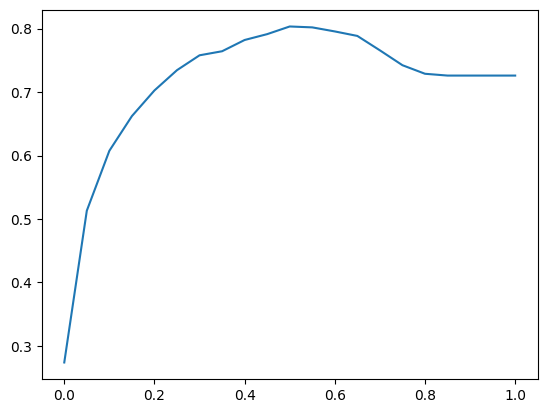

In [11]:
plt.plot(thresholds, scores)

In [12]:
from sklearn.metrics import accuracy_score

In [13]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [14]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.513
0.10 0.608
0.15 0.662
0.20 0.703
0.25 0.735
0.30 0.758
0.35 0.764
0.40 0.782
0.45 0.791
0.50 0.803
0.55 0.802
0.60 0.796
0.65 0.789
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


In [15]:
from collections import Counter

In [16]:
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

In [17]:
Counter(y_val) 
# class imbalance -> there is a lot more data for non churning -> 3:1 ratio 

Counter({np.int64(0): 1023, np.int64(1): 386})

## Confusion table

In [18]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [19]:
actual_positive, actual_negative

(array([False, False, False, ..., False,  True,  True]),
 array([ True,  True,  True, ...,  True, False, False]))

In [20]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [21]:
predict_positive, predict_negative

(array([False, False, False, ..., False,  True,  True]),
 array([ True,  True,  True, ...,  True, False, False]))

In [22]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [23]:
tp, tn, fp, fn

(np.int64(212), np.int64(920), np.int64(103), np.int64(174))

In [24]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])

confusion_matrix

array([[920, 103],
       [174, 212]])

In [25]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## Precision and Recall

In [26]:
(tp + tn) / (tp + tn + fp + fn)

np.float64(0.8034066713981547)

Precision
- fraction of positive predictions that are correct

In [27]:
p = tp / (tp + fp)
p

np.float64(0.6730158730158731)

Recall
- fraction of correctly identified positive examples

In [28]:
r = tp / (tp + fn)
r

np.float64(0.5492227979274611)

## ROC Curves
(Receiver Operating Characteristics)
- it is a method of describing performance of a binary classification model

FPR (False Positive Rate) -> fraction of false positives among all positive examples
```
FPR = FP / (TN + FP)
```

TPR (True Positive Rate) -> fraction of true positive over the total number of positive examples
```
TPR = TP / (FN + TP)
```

In [29]:
tpr = tp / (tp + fn)
tpr

np.float64(0.5492227979274611)

In [30]:
r

np.float64(0.5492227979274611)

In [31]:
fpr = fp / (fp + tn)
fpr

np.float64(0.10068426197458455)

In [32]:
scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))
    

In [33]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,threshold,tp,fp,fn,tn
0,0.00,386,1023,0,0
1,0.01,385,895,1,128
2,0.02,383,804,3,219
3,0.03,382,750,4,273
4,0.04,382,709,4,314
...,...,...,...,...,...
96,0.96,0,0,386,1023
97,0.97,0,0,386,1023
98,0.98,0,0,386,1023
99,0.99,0,0,386,1023


In [34]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,386,1023,0,0
10,0.1,366,533,20,490
20,0.2,339,372,47,651
30,0.3,292,247,94,776
40,0.4,254,175,132,848
50,0.5,212,103,174,920
60,0.6,151,53,235,970
70,0.7,69,13,317,1010
80,0.8,4,0,382,1023
90,0.9,0,0,386,1023


In [35]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [36]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,533,20,490,0.948187,0.521017
20,0.2,339,372,47,651,0.878238,0.363636
30,0.3,292,247,94,776,0.756477,0.241447
40,0.4,254,175,132,848,0.658031,0.171065
50,0.5,212,103,174,920,0.549223,0.100684
60,0.6,151,53,235,970,0.391192,0.051808
70,0.7,69,13,317,1010,0.178756,0.012708
80,0.8,4,0,382,1023,0.010363,0.000000
90,0.9,0,0,386,1023,0.000000,0.000000


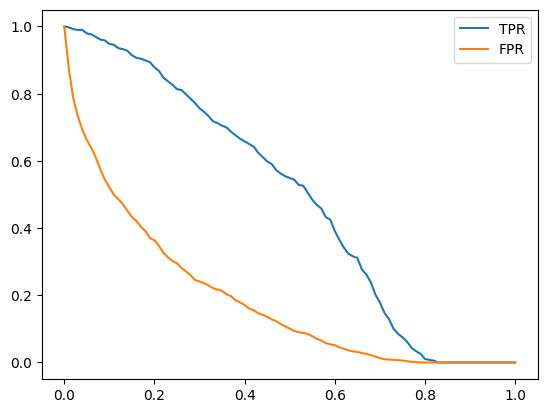

In [37]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')
plt.legend()

### Random model

In [38]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [39]:
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [40]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        
        scores.append((t, tp, fp, fn, tn))
    
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores    

In [41]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [42]:
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


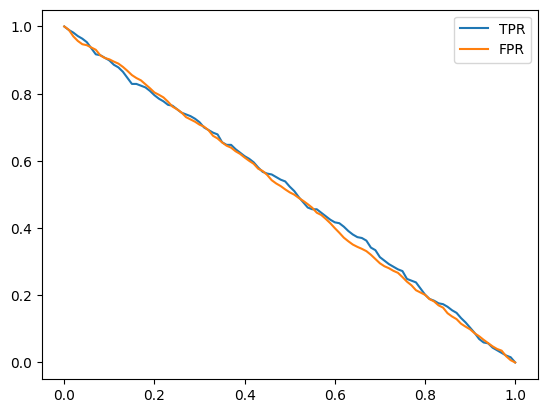

In [43]:
plt.plot(df_rand.threshold, df_rand.tpr, label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')
plt.legend()

### Ideal Model

In [44]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

num_neg, num_pos

(np.int64(1023), np.int64(386))

In [45]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [46]:
y_ideal_pred = np.linspace(0, 1, len(y_val))
y_ideal_pred


array([0.00000000e+00, 7.10227273e-04, 1.42045455e-03, ...,
       9.98579545e-01, 9.99289773e-01, 1.00000000e+00])

In [47]:
1 - y_val.mean()

np.float64(0.7260468417317246)

In [48]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

np.float64(1.0)

In [49]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

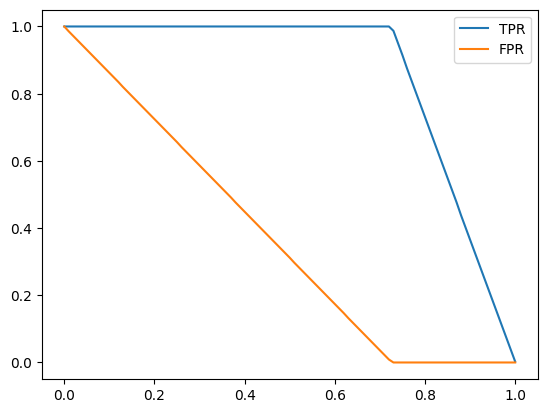

In [50]:
plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR')
plt.legend()

## Putting it all together

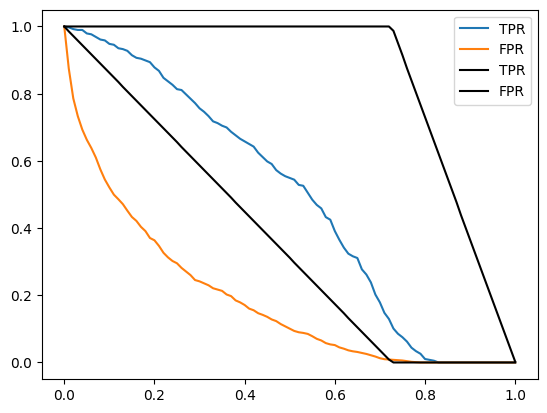

In [51]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')

# plt.plot(df_rand.threshold, df_rand.tpr, label='TPR')
# plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')

plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR', color='black')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR', color='black')
plt.legend()

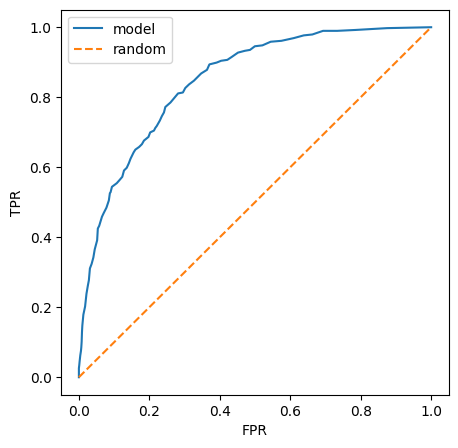

In [52]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot([0, 1], [0, 1], label='random', linestyle='--')
# plt.plot(df_rand.fpr, df_rand.tpr, label='random')
# plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [53]:
from sklearn.metrics import roc_curve

In [54]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

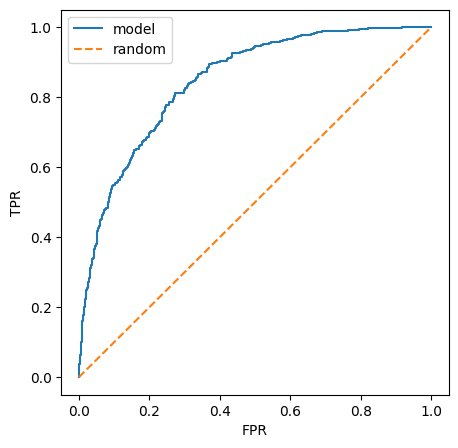

In [55]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='model')
plt.plot([0, 1], [0, 1], label='random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

## ROC AUC (area under the curve)

In [56]:
from sklearn.metrics import auc

In [57]:
auc(fpr, tpr)

np.float64(0.8463044282031412)

In [58]:
auc(df_scores.fpr, df_scores.tpr)

np.float64(0.8460600489265039)

In [59]:
auc(df_ideal.fpr, df_ideal.tpr)

np.float64(0.9999430203759136)

In [60]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

np.float64(0.8463044282031412)

In [61]:
from sklearn.metrics import roc_auc_score

In [62]:
roc_auc_score(y_val, y_pred)

np.float64(0.8463044282031412)

In [63]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [64]:
import random

In [66]:
n = 100000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success += 1

success / n

0.84662

In [70]:
n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

np.float64(0.84904)

## Cross Validation

K-fold cros validation

In [93]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=10000)
    model.fit(X_train, y_train)

    return dv, model

In [74]:
dv, model = train(df_train, y_train)

In [75]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X =  dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [77]:
y_pred = predict(df_val, dv, model)

In [78]:
from sklearn.model_selection import KFold

In [79]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [87]:
from tqdm.auto import tqdm

In [99]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    scores = []

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))


  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.008
C=0.1 0.842 +- 0.007
C=0.5 0.842 +- 0.007
C=1 0.842 +- 0.007
C=5 0.842 +- 0.007
C=10 0.842 +- 0.007


In [100]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

np.float64(0.8584005005037537)